In [1]:
import pandas as pd
import numpy as np

# data preprocessing
from sklearn import preprocessing

# exploratory analysis
import matplotlib.pyplot as plt
import mlxtend
from mlxtend.plotting import scatterplotmatrix
from mlxtend.plotting import heatmap
import seaborn as sns
from IPython.display import Image

# model fit
import statsmodels.api as sm
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

# ignore warnings (libraries are rapidly changing)
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import r2_score

top_200_df = pd.read_csv("./Top_200_Stream_Count_Regression_Dataset.csv")

In [15]:
top_200_df.columns

Index(['duration_ms', 'explicit', 'danceability', 'energy', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'total_follower_count', 'log_total_follower_count',
       'streams', 'log_artist_streams', 'year', 'day_of_week_0',
       'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
       'day_of_week_5', 'day_of_week_6', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12'],
      dtype='object')

In [2]:
# immediately drop some columns that we will not be using.
drop_columns = [
    'id',
    'name',
    'artists',
    'id_artists',
    'mode',
    'tempo',
    'track_id',
    'time_signature',
    'key',
    'top_200_presence', # these are all true anyways
    'popularity', # this isn't something you can control
]
top_200_df = top_200_df.drop(drop_columns, axis=1)

In [3]:
top_200_df['month'] = pd.DatetimeIndex(top_200_df['release_date']).month
top_200_df['year'] = pd.DatetimeIndex(top_200_df['release_date']).year
top_200_df['day_of_week'] = pd.DatetimeIndex(top_200_df['release_date']).dayofweek # 0 is Monday

In [4]:
top_200_df.query('day_of_week == "0"').head(5)

,duration_ms,explicit,release_date,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,total_follower_count,log_total_follower_count,streams,log_artist_streams,month,year,day_of_week
205,185487,0,2020-12-21,0.641,0.324,-5.851,0.0299,0.6980,0.00000,0.3280,0.273,78900234.0,26.233526,58573888.0,25.803754,12,2020,0
233,258639,0,2018-11-05,0.767,0.709,-4.470,0.3360,0.3230,0.00000,0.0676,0.720,12448153.0,23.569428,55154534.0,25.716976,11,2018,0
271,239836,1,2018-12-10,0.511,0.566,-7.230,0.2000,0.3490,0.00000,0.3400,0.218,16996777.0,24.018758,50793507.0,25.598141,12,2018,0
280,187427,0,2020-09-21,0.824,0.457,-5.428,0.0543,0.1670,0.00000,0.0410,0.950,8342103.0,22.991980,49696086.0,25.566629,9,2020,0
336,190570,0,2020-01-13,0.775,0.696,-5.184,0.0681,0.0559,0.00184,0.1570,0.775,38537718.0,25.199768,44685421.0,25.413301,1,2020,0


In [5]:
# no longer need the release_date, as one-hot encodings have been made for week, year, and month
top_200_df = top_200_df.drop(['release_date'], axis=1)

In [6]:
# get one-hot encodings for both day_of_week and month
top_200_df = pd.get_dummies(top_200_df, columns=['day_of_week'])
top_200_df = pd.get_dummies(top_200_df, columns=['month'])

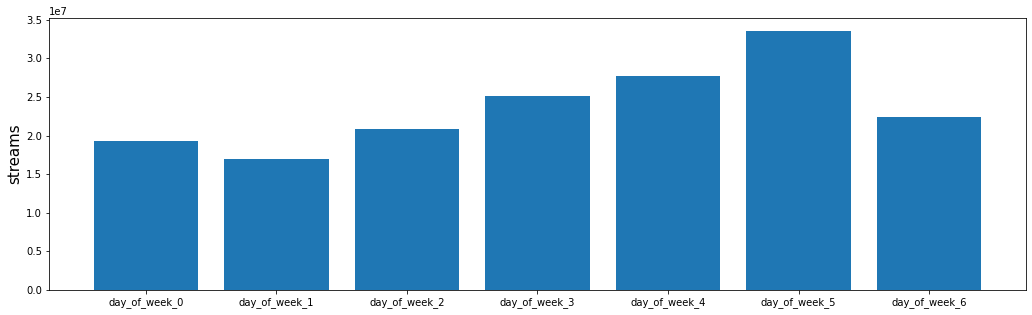

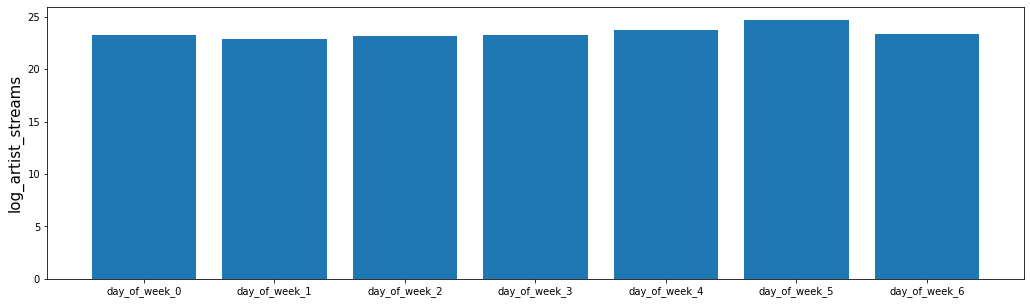

In [7]:
# # takes in a list of column names, representing one-hot encodings (like day_of_week_1, 2, etc...)
def visualize_bar_charts(encodings, target_feature="log_artist_streams"):
    encoding_average_map = {}
    for encoding in encodings:
        average_target_feature = top_200_df.query(f'{encoding} == "1"')[target_feature].mean()
        encoding_average_map[encoding] = average_target_feature
    labels = list(encoding_average_map.keys())
    values = list(encoding_average_map.values())
    f = plt.figure()
    f.set_figwidth(len(labels) * 2.5)
    f.set_figheight(5)
    plt.bar(range(len(labels)), values, tick_label=labels)
    plt.ylabel(target_feature, fontsize = 15)
    plt.show()

day_of_week_encodings = []
for i in range(0,7):
    day_of_week_encodings.append(f'day_of_week_{i}')

month_encodings = []
for i in range(1, 12):
    month_encodings.append(f'month_{i}')
    
visualize_bar_charts(day_of_week_encodings, "streams")
visualize_bar_charts(day_of_week_encodings, "log_artist_streams")

# visualize_bar_charts(month_encodings, "streams")
# visualize_bar_charts(month_encodings, "log_artist_streams")
    


In [8]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(200, activation='relu'),
      layers.Dense(200, activation='relu'),
      layers.Dense(200, activation='relu'),
      layers.Dense(200, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [9]:
def test_model(target_feature, drop_features=[]):
    # drop the non target feature, so it is not used in the model building.
    dataset = None
    if target_feature == 'streams':
        dataset = top_200_df.drop(['log_artist_streams'], axis=1)
    else:
        dataset = top_200_df.drop(['streams'], axis=1)
        
    # drop other features
    dataset = dataset.drop(drop_features, axis=1)
    
    # split into train and test
    train_dataset = dataset.sample(frac=0.8, random_state=0)
    test_dataset = dataset.drop(train_dataset.index)
    
    train_features = train_dataset.copy()
    test_features = test_dataset.copy()

    train_labels = train_features.pop(target_feature)
    test_labels = test_features.pop(target_feature)
    
    normalizer = tf.keras.layers.Normalization(axis=-1)
    normalizer.adapt(np.array(train_features).astype('float32'))
    
    dnn_model = build_and_compile_model(normalizer)
    dnn_model.summary()
    
    train_features = train_features.astype(float)
    train_labels = train_labels.astype(float)

    test_features = test_features.astype(float)
    test_labels = test_labels.astype(float)
    
    history = dnn_model.fit(
        train_features,
        train_labels,
        validation_split=0.2,
        verbose=0, epochs=200)
    
    predicted_labels = dnn_model.predict(test_features)
    actual_labels = list(test_labels)
    coefficient_of_dermination = r2_score(actual_labels, predicted_labels)
    print(coefficient_of_dermination)

In [17]:
test_model('streams', drop_features=[])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  (None, 32)               65        
 ion)                                                            
                                                                 
 dense_15 (Dense)            (None, 200)               6600      
                                                                 
 dense_16 (Dense)            (None, 200)               40200     
                                                                 
 dense_17 (Dense)            (None, 200)               40200     
                                                                 
 dense_18 (Dense)            (None, 200)               40200     
                                                                 
 dense_19 (Dense)            (None, 1)                 201       
                                                      

In [16]:
test_model('streams', drop_features=['total_follower_count', 'log_total_follower_count'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 30)               61        
 ion)                                                            
                                                                 
 dense_10 (Dense)            (None, 200)               6200      
                                                                 
 dense_11 (Dense)            (None, 200)               40200     
                                                                 
 dense_12 (Dense)            (None, 200)               40200     
                                                                 
 dense_13 (Dense)            (None, 200)               40200     
                                                                 
 dense_14 (Dense)            (None, 1)                 201       
                                                      